<a href="https://colab.research.google.com/github/I-PHEN/PET_CLASSIFIER/blob/main/Pet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pet Image Classifier

This notebook guides you through building and deploying a simple image classifier to identify different breeds of pets using the `fastai` library. We'll cover everything from loading and preparing the data to training a deep learning model and creating a web interface to demonstrate its capabilities. The goal is to create a notebook that is easy to follow and understand, even if you're new to deep learning.

## Setup and Imports

First, we need to import the necessary libraries. We'll be using `fastai.vision` for our vision tasks, `timm` to access a variety of pre-trained models, and `gradio` to create a simple web interface for our classifier.

In [28]:
from fastai.vision.all import *
import timm
from fastai.vision.widgets import *
import gradio as gr

## Data Loading and Preparation

This section handles the downloading, organizing, and preparing of the dataset for our image classification model. We use the `fastai` library, which provides convenient functions for this purpose.

We start by downloading the Oxford-IIIT Pet Dataset using `untar_data(URLs.PETS)`. This function downloads the dataset from the specified URL (`URLs.PETS`) and extracts it to a local directory. The path to the extracted data is stored in the `path` variable.

Next, we use `ImageDataLoaders.from_name_func` to create a `DataLoaders` object. This object is crucial for managing our dataset and providing data to the model during training and validation. Let's break down the arguments used:

- `path`: Specifies the root directory of our dataset.
- `get_image_files(path)`: This function finds all image files within the specified path.
- `valid_pct = 0.2`: This allocates 20% of the data for the validation set, leaving the remaining 80% for the training set. This split is important for evaluating the model's performance on unseen data.
- `seed = 42`: Setting a seed ensures that the random splitting of data into training and validation sets is reproducible.
- `label_func = RegexLabeller(pat=r'^([^/]+)_\d+')`: This is a key part of extracting labels from the filenames. The `RegexLabeller` uses a regular expression pattern (`r'^([^/]+)_\d+'`) to extract the breed name (which is our label) from each filename. The pattern looks for any characters at the beginning of the string (`^`) up to the first underscore (`_`) followed by one or more digits (`\d+`). The part within the parentheses `([^/]+)` is captured as the label.
- `item_tfms = Resize(224)`: This applies transformations to individual image items. `Resize(224)` resizes all images to a standard size of 224x224 pixels. This is necessary because deep learning models typically require input images of a fixed size.

Finally, `dls.show_batch(max_n = 3, nrows=1)` displays a small batch of images from the dataloaders with their corresponding labels. This helps us visually inspect if the data has been loaded and labeled correctly.

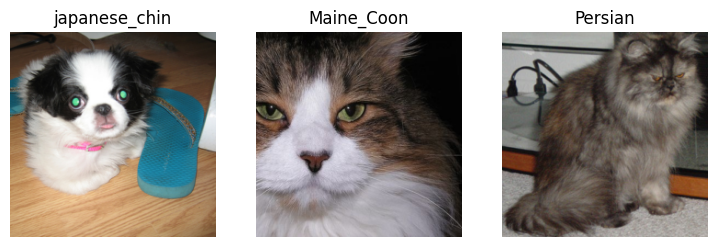

In [29]:
path = untar_data(URLs.PETS)/'images'
dls = ImageDataLoaders.from_name_func(path,
    get_image_files(path),
    valid_pct = 0.2,
    seed = 42,
    label_func = RegexLabeller(pat=r'^([^/]+)_\d+'),
    item_tfms = Resize(224)

)
dls.show_batch(max_n = 3, nrows=1)

*Explanation of the output from the previous cell:*
The output above shows a batch of images from the dataset with their corresponding labels, confirming that the data has been loaded and the labels have been correctly extracted from the filenames.

## Creating and Fine-tuning the Vision Learner

In this section, we set up and train our image classification model using `fastai`. We'll use a pre-trained convolutional neural network (CNN) architecture and fine-tune it on our pet dataset. This approach, known as **transfer learning**, is very effective because the pre-trained model has already learned powerful features from a large dataset (like ImageNet), and we only need to adjust it slightly for our specific task.

Initially, we attempted to use the `resnet34` architecture:

In [30]:
learn = vision_learner(dls, resnet34 , metrics = error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.456838,0.341614,0.101489,00:40


epoch,train_loss,valid_loss,error_rate,time
0,0.437359,0.355746,0.110284,00:43
1,0.279889,0.272732,0.081867,00:48
2,0.128307,0.247266,0.077808,00:45


*Explanation of the output from the previous cell:*
The output shows the training progress for the `resnet34` model over 3 epochs. It displays the training loss, validation loss, and error rate for each epoch.

After the initial attempt with `resnet34`, we explored other architectures using `timm.list_models('convnext*')`. This command lists available models from the `timm` library that match the pattern 'convnext*', allowing us to see alternative architectures we could use.

In [31]:
timm.list_models('convnext*')

['convnext_atto',
 'convnext_atto_ols',
 'convnext_atto_rms',
 'convnext_base',
 'convnext_femto',
 'convnext_femto_ols',
 'convnext_large',
 'convnext_large_mlp',
 'convnext_nano',
 'convnext_nano_ols',
 'convnext_pico',
 'convnext_pico_ols',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge',
 'convnext_xxlarge',
 'convnext_zepto_rms',
 'convnext_zepto_rms_ols',
 'convnextv2_atto',
 'convnextv2_base',
 'convnextv2_femto',
 'convnextv2_huge',
 'convnextv2_large',
 'convnextv2_nano',
 'convnextv2_pico',
 'convnextv2_small',
 'convnextv2_tiny']

*Explanation of the output from the previous cell:*
This output is a list of various ConvNeXt model architectures available in the `timm` library. We can choose one of these models for our image classifier.

Based on the available models, we decided to try a different architecture, `convnext_tiny`, which is a more modern and often performant architecture. We also convert the model to use 16-bit floating-point precision using `.to_fp16()` to potentially reduce memory usage and speed up training.

In [32]:
learn = vision_learner(dls, 'convnext_tiny'  , metrics = error_rate).to_fp16()
learn.fine_tune(2)

/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()
/usr/local/lib/python3.12/dist-packages/fastai/callback/fp16.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.autocast,self.learn.scaler,self.scales = autocast(dtype=dtype),GradScaler(**self.kwargs),L()


epoch,train_loss,valid_loss,error_rate,time
0,0.957763,0.225913,0.079161,00:41


epoch,train_loss,valid_loss,error_rate,time
0,0.251969,0.184863,0.057510,00:44
1,0.160989,0.177826,0.050068,00:42


*Explanation of the output from the previous cell:*
This output shows the training progress for the `convnext_tiny` model fine-tuned for 2 epochs. Similar to the previous training output, it displays the loss and error rate, allowing us to evaluate the model's performance.

## Saving and Loading the Trained Model

Once the model is trained, we need to save it so we can use it later for making predictions without retraining. `fastai` provides a convenient method for this: `learn.export()`.

In [33]:
learn.export('/content/model.pkl')

*Explanation of the output from the previous cell:*
This cell does not produce a visible output, but it saves the trained model to a file named `model.pkl` in the `/content/` directory.

To use the saved model for inference (making predictions on new images), we need to load it back into memory. `fastai` provides the `load_learner()` function for this purpose.

In [34]:
learn_inf = load_learner('/content/model.pkl')

/usr/local/lib/python3.12/dist-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


*Explanation of the output from the previous cell:*
This cell loads the saved model from the `model.pkl` file into the `learn_inf` variable. You might see a warning about using `pickle`, which is a standard Python module for saving and loading objects, but it's safe to ignore in this case since we are loading a file we just saved.

## Making Predictions on Individual Images

Now that we have loaded the trained model, we can use it to make predictions on new, unseen images. We'll first create a file upload widget to allow users to provide an image.

In [35]:
uploader =  widgets.FileUpload()
uploader

FileUpload(value={}, description='Upload')

*Explanation of the output from the previous cell:*
This cell displays a file upload widget. You can use this widget to upload an image file that you want the model to classify.

After uploading an image using the widget, we can create a PIL image object from the uploaded file and resize it to the expected input size of our model (224x224 pixels).

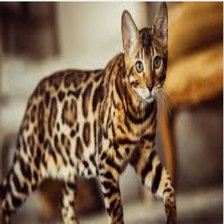

In [42]:
img = PILImage.create(uploader.data[0])
img.resize((224, 224))

*Explanation of the output from the previous cell:*
This cell processes the uploaded image, creating a PIL image object and resizing it. The output confirms that an image object has been created and its size is 224x224 pixels.

We can then use the loaded model (`learn_inf`) to make a prediction on the uploaded image.

In [43]:
learn_inf.predict(img)

('Bengal',
 tensor(1),
 tensor([2.3876e-06, 9.9837e-01, 4.6621e-07, 1.7692e-05, 4.0883e-07, 1.5236e-03,
         7.0309e-05, 4.3713e-08, 1.5991e-07, 5.2538e-07, 8.0427e-08, 2.6812e-06,
         7.0533e-08, 3.1378e-06, 8.9056e-07, 9.1441e-08, 1.2554e-06, 2.1655e-07,
         5.3179e-08, 3.2518e-07, 1.3392e-07, 1.4128e-06, 2.3132e-07, 3.0799e-07,
         8.3099e-07, 7.6012e-07, 7.8676e-07, 6.1749e-08, 4.8435e-07, 9.1067e-08,
         9.2711e-08, 6.9988e-08, 2.1630e-06, 1.3602e-08, 3.0810e-07, 2.4248e-07,
         5.4977e-07]))

*Explanation of the output from the previous cell:*
This cell outputs the prediction from the model for the uploaded image. The output is a tuple containing the predicted class label (the pet breed), the index of the predicted class, and a tensor of probability scores for all possible classes.

To make it easier to interpret the probabilities and prepare for creating a web interface, we retrieve the list of all possible categories (pet breeds) that the model can classify.

In [38]:
categories = learn_inf.dls.vocab

*Explanation of the output from the previous cell:*
This cell does not produce a visible output, but it stores the list of all possible pet breed categories in the `categories` variable.

We define a classification function `pet_classifier` that takes an image as input, uses the loaded model to predict the probabilities for each category, and returns a dictionary mapping each category to its probability. This format is suitable for use with Gradio.

In [39]:
def pet_classifier(img):
  pred,pred_idx,probs = learn_inf.predict(img)
  return dict(zip(categories, map(float, probs)))

*Explanation of the output from the previous cell:*
This cell defines the `pet_classifier` function. It does not produce a visible output when executed.

We can test the `pet_classifier` function with the uploaded image to see the predicted probabilities in a dictionary format.

In [40]:
pet_classifier(img)

{'Abyssinian': 1.3297175200932543e-06,
 'Bengal': 1.0581018159427913e-06,
 'Birman': 1.5127742472031969e-06,
 'Bombay': 9.477001583491074e-08,
 'British_Shorthair': 3.8634851762253675e-07,
 'Egyptian_Mau': 3.5475029562803684e-06,
 'Maine_Coon': 2.66640222434944e-06,
 'Persian': 5.1814248536175e-07,
 'Ragdoll': 3.0880684676048986e-07,
 'Russian_Blue': 1.1678308510454372e-05,
 'Siamese': 2.8700540042336797e-06,
 'Sphynx': 4.939022915095848e-07,
 'american_bulldog': 1.387708607580862e-06,
 'american_pit_bull_terrier': 1.980558153036327e-07,
 'basset_hound': 0.9962336421012878,
 'beagle': 0.003633888904005289,
 'boxer': 1.2187229003757238e-06,
 'chihuahua': 3.916372406820301e-06,
 'english_cocker_spaniel': 2.4932001906563528e-05,
 'english_setter': 1.8426330825604964e-06,
 'german_shorthaired': 2.672020400495967e-06,
 'great_pyrenees': 4.7869943955447525e-06,
 'havanese': 1.806616069188749e-06,
 'japanese_chin': 2.902387450376409e-06,
 'keeshond': 2.31113335757982e-06,
 'leonberger': 4.719

*Explanation of the output from the previous cell:*
This output shows the result of calling the `pet_classifier` function with the uploaded image. It's a dictionary where the keys are the pet breed names and the values are the corresponding probability scores predicted by the model.

## Creating a Web Interface with Gradio

To make our pet image classifier easily usable and shareable, we can build a simple web interface using the `gradio` library. Gradio allows you to quickly create customizable UI components around your machine learning models.

In [41]:
image = gr.Image(height=400, width=400)
label = gr.Label()
layout = gr.Interface(fn = pet_classifier, inputs=image, outputs=label)
layout.launch(inline=False)

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d67948dc3e9514caba.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


*Explanation of the output from the previous cell:*
This cell launches the Gradio web interface for the pet image classifier. The output provides a local URL and potentially a public URL (if running on a hosted environment like Colab with `share=True`) that you can click to access the interactive demo in your browser.

## Project Summary and Next Steps

This notebook demonstrates the process of building and deploying a simple image classification model using the `fastai` library. We started by downloading and preparing the Oxford-IIIT Pet Dataset, then trained a convolutional neural network (specifically, a fine-tuned ConvNeXt Tiny model) to classify images of pets into their respective breeds. Finally, we created a basic web interface using `gradio` to allow users to easily upload an image and get a prediction from our trained model.

**What was achieved:**

- Successfully loaded and prepared an image dataset for a deep learning model.
- Trained an image classification model using transfer learning with a modern CNN architecture (`convnext_tiny`).
- Exported the trained model for later use.
- Created a simple, interactive web demo using `gradio` to showcase the model's predictions.

**Potential Next Steps:**

- **Improve Model Accuracy:** Explore other model architectures, experiment with different hyperparameters, or use more advanced data augmentation techniques to potentially improve the model's accuracy.
- **Expand the Dataset:** Include more images or more pet breeds to make the classifier more robust and versatile.
- **Add More Features to the Interface:** Enhance the Gradio interface with features like displaying the top N predictions with their probabilities, providing example images, or adding a feedback mechanism.
- **Deploy to a Permanent Platform:** Deploy the Gradio application to a more permanent hosting platform (like Hugging Face Spaces, Render, or your own server) so it's continuously available.
- **Explore Other Applications:** Adapt the techniques learned here to build image classifiers for other types of objects or images.